In [221]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

#Read and preprocessing

In [222]:
def read(data, label):
  mp = {' ': 0, '+': 1, '#': 1}
  X = []
  with open(data, 'r') as file:

    while True:
      img = []

      for _ in range(28):
        line = file.readline()

        if not line:
          break

        row = [mp[c] for c in line if c != '\n']
        img.append(row)

      if not line:
        break
      while len(img) != 28:
        img.append([0] * 28)
      X.append(img)

    file.close()

  with open(label, 'r') as file:
    y = [int(line) for line in file]
    file.close()


  y = np.array(y)
  X = np.array(X)

  return X, y

# def extract_features(X):
#   num_images, height, width = X.shape
#   features = np.zeros((num_images, 14, 14), dtype=int)

#   for idx in range(num_images):
#     for i in range(0, height, 2):
#       for j in range(0, width, 2):
#         block = X[idx, i:i+2, j:j+2]
#         majority_value = Counter(block.flatten()).most_common(1)[0][0]
#         features[idx, i // 2, j // 2] = majority_value

#     return features

def view(X, idx):
  for i in range(28):
    for j in range(28):
      print(X[idx, i, j], end='')
    print()

def confusion_matrix(y_true, y_pred):
  num_classes = len(np.unique(y_true))
  confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

  for true_label, pred_label in zip(y_true, y_pred):
    confusion_matrix[true_label, pred_label] += 1

  return confusion_matrix
def accuracy_fn(y_true, y_pred):
  return np.sum(y_true == y_pred) / len(y_true)

In [223]:
X_train, y_train = read('trainingimages', 'traininglabels')
X_test, y_test = read('testimages', 'testlabels')

In [224]:
# X_train = extract_features(X_train)
# X_test = extract_features(X_test)

In [225]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

#Model

In [226]:
class NaiveBayes:

  def fit(self, X, y, alpha=3):

    n_samples, n_features = X.shape
    self._classes = np.unique(y)
    n_classes = len(self._classes)

    self.alpha = alpha
    self._var = np.zeros((n_classes, n_features), dtype=np.float64)
    self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
    self._priors = np.zeros(n_classes, dtype=np.float64)

    for i, val in enumerate(self._classes):
      sep = X[y == val]
      self._mean[i, :] = sep.mean(axis=0)
      self._var[i, :] = sep.var(axis=0) + alpha
      self._priors[i] = (sep.shape[0])/ (float(n_samples))

  def predict(self, X):
    y_pred = [self._predict(x) for x in X]
    return np.array(y_pred)

  def _predict(self, x):
    posteriors = []

    for i, c in enumerate(self._classes):
      prior = np.log(self._priors[i])
      pdf = self._pdf(i, x)

      posterior = np.sum(np.log(pdf)) + prior
      posteriors.append(posterior)

    return self._classes[np.argmax(posteriors)]

  def _pdf(self, class_idx, x):
    mean = self._mean[class_idx]
    var = self._var[class_idx] + self.alpha

    numerator = np.exp(-((x - mean) ** 2) / (2 * var))
    denominator = np.sqrt(2 * np.pi * var)
    return numerator / denominator

In [227]:
import numpy as np

class MultinomialNaiveBayes:
  def fit(self, X, y, alpha=1.0):

    n_samples, n_features = X.shape
    self.classes = np.unique(y)
    n_classes = len(self.classes)

    self.class_priors = np.zeros(n_classes, dtype=np.float64)
    self.feature_likelihoods = np.zeros((n_classes, n_features), dtype=np.float64)

    for idx, cls in enumerate(self.classes):
      X_cls = X[y == cls]

      self.class_priors[idx] = X_cls.shape[0] / float(n_samples)
      class_feature_count = X_cls.sum(axis=0) + alpha
      total_feature_count = X_cls.sum() + alpha * n_features

      self.feature_likelihoods[idx, :] = class_feature_count / total_feature_count

  def predict(self, X):

    y_pred = [self._predict(x) for x in X]
    return np.array(y_pred)

  def _predict(self, x):
    posteriors = []

    for idx, cls in enumerate(self.classes):
      prior = np.log(self.class_priors[idx])
      likelihood = np.sum(x * np.log(self.feature_likelihoods[idx]))
      posterior = prior + likelihood
      posteriors.append(posterior)

    return self.classes[np.argmax(posteriors)]


#Finetune + Laplace smoothing

In [228]:
best = -1
smooth = -1

acc_ = []
f = [0.001, 0.0015, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045,
    0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095]
model = MultinomialNaiveBayes()
for i in f:
  model.fit(X_train, y_train, alpha=i)
  y_pred = model.predict(X_test)
  accuracy = np.sum(y_pred == y_test) / len(y_test)
  acc_.append(accuracy)
  if accuracy > best:
    best = accuracy
    smooth = i

print(best, smooth)

0.758 0.001


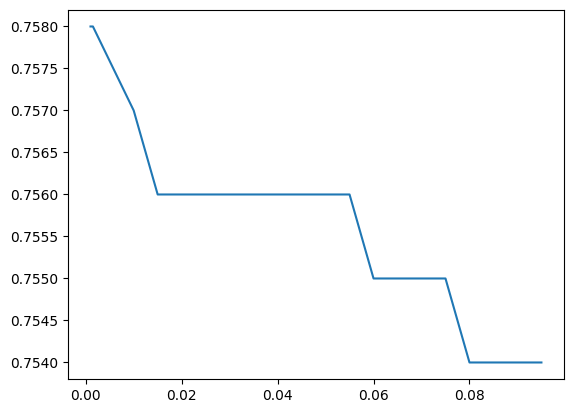

In [229]:
plt.plot(f, acc_)
plt.show()

#Fit and Evaluate

In [230]:
model = MultinomialNaiveBayes()
model.fit(X_train, y_train, smooth)
y_pred = model.predict(X_test)

In [231]:
acc = accuracy_fn(y_pred, y_test)
print(f'Accuracy: {acc*100:.1f}%')
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion matrix:\n {pd.DataFrame(cm)}')

Accuracy: 75.8%
Confusion matrix:
     0    1   2   3   4   5   6   7   8   9
0  78    0   1   1   0   2   3   0   5   0
1   0  102   0   0   0   0   1   0   5   0
2   1    3  76   3   2   1   6   1  10   0
3   0    1   0  83   0   2   2   5   1   6
4   0    0   2   0  70   1   4   0   2  28
5   2    1   1  15   4  52   1   1   8   7
6   1    4   3   0   2   3  74   0   4   0
7   0    5   3   0   3   0   0  75   4  16
8   1    2   3  14   3   4   0   2  65   9
9   1    1   0   2   7   1   0   1   4  83


In [232]:
model2 = NaiveBayes()
model2.fit(X_train, y_train, alpha=smooth)
pred = model2.predict(X_test)

<ipython-input-226-4689a370d748>:31: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(pdf)) + prior


In [233]:
acc2 = accuracy_fn(pred, y_test)
print(f'Accuracy: {acc*100:.1f}%')
cm2 = confusion_matrix(y_test, pred)
print(f'Confusion matrix:\n {pd.DataFrame(cm)}')

Accuracy: 75.8%
Confusion matrix:
     0    1   2   3   4   5   6   7   8   9
0  78    0   1   1   0   2   3   0   5   0
1   0  102   0   0   0   0   1   0   5   0
2   1    3  76   3   2   1   6   1  10   0
3   0    1   0  83   0   2   2   5   1   6
4   0    0   2   0  70   1   4   0   2  28
5   2    1   1  15   4  52   1   1   8   7
6   1    4   3   0   2   3  74   0   4   0
7   0    5   3   0   3   0   0  75   4  16
8   1    2   3  14   3   4   0   2  65   9
9   1    1   0   2   7   1   0   1   4  83


In [234]:
# from sklearn.naive_bayes import MultinomialNB
# model = MultinomialNB()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# accuracy_fn(y_test, y_pred)

In [235]:
# pd.DataFrame(confusion_matrix(y_test, y_pred))

#Save and Load model



In [236]:
import pickle

**Save**

In [237]:
f = open('Nb.pkl', 'wb')
pickle.dump(model, f)
f.close()

**Load**

In [238]:
f = open('Nb.pkl', 'rb')
classif = pickle.load(f)
f.close()

In [240]:
(classif.predict(X_test) == y_test).sum() / len(y_test)

0.758